In [29]:
#pip install mlflow

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import mlflow
import mlflow.keras

### 5.1 Data reading

In [31]:
class DataReader:
    @staticmethod
    def read_csv(file_path: str) -> pd.DataFrame:
        """"Wheather data and polygons"""
        df = pd.read_csv(file_path, parse_dates=["TIMESTAMP"])
        return df

### 5.2 Data cleaning

In [32]:
class DataCleaner:
    @staticmethod
    def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
        # Create hour of day
        df['hour'] = df['TIMESTAMP'].dt.hour
        return df
#       #
#        # Create season feature based on month (0: Winter, 1: Spring, 2: Summer, 3: Autumn)
#        def get_season(month):
#            if month in [12, 1, 2]:
#                return 0  # Winter
#            elif month in [3, 4, 5]:
#                return 1  # Spring
#            elif month in [6, 7, 8]:
#                return 2  # Summer
#            else:
#                return 3  # Autumn#
#        df['season'] = df['TIMESTAMP'].dt.month.apply(get_season)
#        return df

    @staticmethod
    def sort_by_id_and_time(df: pd.DataFrame) -> pd.DataFrame:
        df = df.sort_values(['ID_INDIVIDUAL_IDENTIFIER', 'TIMESTAMP'])
        df = df.reset_index(drop=True)
        return df

### 5.3 Sequence Generator

In [33]:
class SequenceGenerator:
    def __init__(self, seq_length: int, feature_cols: list, target_cols: list = ['LOCATION_LONG', 'LOCATION_LAT'],
                 oversample_threshold: float = 0.0005, oversample_factor: int = 3):
        """
        Initializes the SequenceGenerator.

        :param seq_length: Length of the sequence to generate.
        :param feature_cols: List of feature columns to use.
        :param target_cols: List of target columns (default: ['LOCATION_LONG', 'LOCATION_LAT']).
        :param oversample_threshold: Minimum Euclidean distance between the start of the sequence and the target
                                     to consider the movement significant.
        :param oversample_factor: Number of extra copies to generate if the movement is significant.
        """
        self.seq_length = seq_length
        self.feature_cols = feature_cols
        self.target_cols = target_cols
        self.oversample_threshold = oversample_threshold
        self.oversample_factor = oversample_factor
        self.scaler = StandardScaler()  # Feature scaling
        self.target_scaler = StandardScaler()  # Target variable scaling

    def generate_sequences(self, df: pd.DataFrame) -> (np.ndarray, np.ndarray, np.ndarray):
        """
        Generates sequences of features and targets from the input DataFrame.

        :param df: Input DataFrame containing the data.
        :return: Tuple containing:
                 - X_scaled: Scaled feature sequences (3D array).
                 - y_scaled: Scaled target values (2D array).
                 - id_list: Array of individual identifiers for each sequence.
        """
        X_list, y_list, id_list = [], [], []
        # Process each individual
        for ind, group in df.groupby('ID_INDIVIDUAL_IDENTIFIER'):
            group = group.reset_index(drop=True)
            data = group[self.feature_cols].values
            targets = group[self.target_cols].values
            n_samples = len(group) - self.seq_length
            for i in range(n_samples):
                seq = data[i:i+self.seq_length]
                target = targets[i+self.seq_length]
                # Calculate the Euclidean distance between the first coordinate and the target
                displacement = np.linalg.norm(seq[0, :2] - target)
                
                # If the distance exceeds the threshold, apply oversampling
                if displacement > self.oversample_threshold:
                    for _ in range(self.oversample_factor):
                        X_list.append(seq)
                        y_list.append(target)
                        id_list.append(ind)
                else:
                    X_list.append(seq)
                    y_list.append(target)
                    id_list.append(ind)
        X = np.array(X_list)
        y = np.array(y_list)
        
        # Scale the features: reshape to 2D, apply scaling, and reshape back to 3D
        num_samples, seq_len, num_features = X.shape
        X_reshaped = X.reshape(-1, num_features)
        X_scaled = self.scaler.fit_transform(X_reshaped)
        X_scaled = X_scaled.reshape(num_samples, seq_len, num_features)
        
        # Normalize the target variable (latitude and longitude)
        y_scaled = self.target_scaler.fit_transform(y)
        
        return X_scaled, y_scaled, np.array(id_list)

### 5.4 Model configuration

In [34]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

class ModelConfig:
    """
    Configuration and construction of an LSTM neural network model for predicting coordinates (latitude, longitude).
    """
    def __init__(self, seq_length: int, num_features: int):
        """
        Initializes the model configuration.
        :param seq_length: Length of the input sequence.
        :param num_features: Number of features per time step.
        """
        if seq_length <= 0 or num_features <= 0:
            raise ValueError("seq_length and num_features must be positive values.")
        self.seq_length = seq_length
        self.num_features = num_features

    @staticmethod
    def weighted_mse(y_true, y_pred):
        """
        Custom loss function that weights the mean squared error (MSE) based on displacement.
        :param y_true: True values.
        :param y_pred: Predicted values.
        :return: Weighted loss.
        """
        displacement = tf.norm(y_true, axis=-1, keepdims=True)
        weights = 1.0 + displacement
        loss = weights * tf.square(y_true - y_pred)
        return tf.reduce_mean(loss)

    def build_model(self) -> tf.keras.Model:
        """
        Builds and compiles an LSTM model.
        :return: Compiled Keras model.
        """
        model = Sequential()
        # LSTM layer with 64 units and Dropout for regularization
        model.add(LSTM(64, input_shape=(self.seq_length, self.num_features), return_sequences=True))
        model.add(tf.keras.layers.Dropout(0.2))
        # Second LSTM layer with 32 units
        model.add(LSTM(32, return_sequences=False))
        # Dense layer with 32 units and ReLU activation
        model.add(Dense(32, activation='relu'))
        # Output layer for latitude and longitude
        model.add(Dense(2))
        # Compile the model with the custom loss function
        model.compile(optimizer='adam', loss=self.weighted_mse)
        return model

### 5.5 Trainer class

In [35]:
class Trainer:
    def __init__(self, model: tf.keras.Model, mlflow_experiment_name: str = "Trajectory_Prediction"):
        self.model = model
        mlflow.set_experiment(mlflow_experiment_name)

    def train(self, X, y, epochs: int = 20, batch_size: int = 32, validation_split: float = 0.2):
        with mlflow.start_run():
            history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
            # Log parameters and metrics to MLflow
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("batch_size", batch_size)
            mlflow.keras.log_model(self.model, "model")
        return history

### 5.6 Evaluator Class

In [36]:
class Evaluator:
    def __init__(self, threshold_km: float = 1.0):
        """
        Initializes the Evaluator with a threshold distance in kilometers.

        :param threshold_km: Distance threshold in kilometers to consider a prediction as correct.
        """
        self.threshold_km = threshold_km

    @staticmethod
    def haversine(lon1, lat1, lon2, lat2):
        """
        Calculates the distance in kilometers between two points using the Haversine formula.

        :param lon1: Longitude of the first point.
        :param lat1: Latitude of the first point.
        :param lon2: Longitude of the second point.
        :param lat2: Latitude of the second point.
        :return: Distance in kilometers.
        """
        R = 6371.0  # Earth's radius in kilometers
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])  # Convert degrees to radians
        dlon = lon2 - lon1  # Difference in longitude
        dlat = lat2 - lat1  # Difference in latitude
        a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2  # Haversine formula
        c = 2 * np.arcsin(np.sqrt(a))  # Central angle
        return R * c  # Distance in kilometers

    def evaluate(self, y_true: np.ndarray, y_pred: np.ndarray, target_scaler: StandardScaler):
        """
        Evaluates the model's predictions by comparing true and predicted coordinates.

        :param y_true: True target values (scaled).
        :param y_pred: Predicted target values (scaled).
        :param target_scaler: Scaler used to normalize the target values.
        :return: Tuple containing accuracy, F1 score, and recall.
        """
        # Reverse the normalization to work with original coordinates
        y_true_inv = target_scaler.inverse_transform(y_true)
        y_pred_inv = target_scaler.inverse_transform(y_pred)
        
        # Calculate hits (1 if prediction is within threshold, 0 otherwise)
        hits = []
        for (lat_true, lon_true), (lat_pred, lon_pred) in zip(y_true_inv, y_pred_inv):
            distance = self.haversine(lon_true, lat_true, lon_pred, lat_pred)
            hits.append(1 if distance < self.threshold_km else 0)
        hits = np.array(hits)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(np.ones_like(hits), hits)
        f1 = f1_score(np.ones_like(hits), hits)
        recall = recall_score(np.ones_like(hits), hits)
        
        # Print evaluation metrics
        print(f"Evaluation Metrics:\nAccuracy: {accuracy:.3f}\nF1 Score: {f1:.3f}\nRecall: {recall:.3f}")
        return accuracy, f1, recall

### 5.6 Predictor Class

In [37]:
class Predictor:
    def __init__(self, model: tf.keras.Model, sequence_generator: SequenceGenerator):
        self.model = model
        self.sequence_generator = sequence_generator

    def predict_next(self, sequence: np.ndarray) -> np.ndarray:
        # Assume that 'sequence' has shape (1, seq_length, num_features)
        pred_norm = self.model.predict(sequence)
        # Convert the predicted target from normalized scale to original scale
        pred = self.sequence_generator.target_scaler.inverse_transform(pred_norm)
        return pred[0]

    def predict_trajectory(self, initial_sequence: np.ndarray, steps: int) -> np.ndarray:
        preds = []
        current_seq = initial_sequence.copy()
        for _ in range(steps):
            # Predict in normalized space and convert to original scale
            next_coord = self.predict_next(current_seq[np.newaxis, ...])
            preds.append(next_coord)
            
            # To update the sequence, the prediction must be transformed to the features' scale.
            # Extract scaling parameters from the feature scaler for the latitude and longitude columns (assumed to be the first ones)
            feature_scaler = self.sequence_generator.scaler
            lat_idx, lon_idx = 0, 1
            lat_mean = feature_scaler.mean_[lat_idx]
            lat_std = feature_scaler.scale_[lat_idx]
            lon_mean = feature_scaler.mean_[lon_idx]
            lon_std = feature_scaler.scale_[lon_idx]
            # Scale the prediction into the same space as the features
            next_coord_scaled = np.array([(next_coord[0] - lat_mean) / lat_std, (next_coord[1] - lon_mean) / lon_std])
            
            next_features = current_seq[-1].copy()
            next_features[0] = next_coord_scaled[0]  # update normalized latitude
            next_features[1] = next_coord_scaled[1]  # update normalized longitude
            # Slide the window: remove the first element and append the updated features
            current_seq = np.concatenate([current_seq[1:], next_features[np.newaxis, :]], axis=0)
        return np.array(preds)
    
    @staticmethod
    def visualize_trajectories(df: pd.DataFrame, ids: np.ndarray, title: str = "Trajectories by Animal ID"):
        plt.figure(figsize=(12, 8))
        unique_ids = np.unique(ids)
        for animal_id in unique_ids:
            subset = df[df['ID_INDIVIDUAL_IDENTIFIER'] == animal_id]
            plt.plot(subset['LOCATION_LONG'], subset['LOCATION_LAT'], marker='o', linestyle='-', label=f'ID {animal_id}', alpha=0.7)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(title)
        plt.legend()
        plt.show()


### 5.7  Pipeline: Main Function

In [38]:
def main():
    # File path to the CSV data
    file_path = "data_pa_gc_final_2.csv"  # Adjust the path accordingly

    # Step 1: Read data
    df = DataReader.read_csv(file_path)
    
    # Step 2: Clean and prepare data
    df = DataCleaner.add_time_features(df)
    df = DataCleaner.sort_by_id_and_time(df)
    
    # Define the features for sequence generation
    feature_cols = ['LOCATION_LONG', 'LOCATION_LAT', 'hour', 'T2M', 'RH2M', 'WS10M', 'PS', 'PRECTOTCORR', 'HIGH']
    target_cols = ['LOCATION_LONG', 'LOCATION_LAT']
    
    # Step 3: Generate sequences (using a sliding window)
    seq_length = 5
    seq_gen = SequenceGenerator(seq_length, feature_cols, target_cols)
    X, y, id_array = seq_gen.generate_sequences(df)
    
    print(f"Generated {X.shape[0]} sequences with shape {X.shape}")

    # Step 4: Configure the model
    num_features = X.shape[2]
    model_config = ModelConfig(seq_length, num_features)
    model = model_config.build_model()
    model.summary()

    # Step 5: Train the model (using MLflow for logging)
    trainer = Trainer(model)
    history = trainer.train(X, y, epochs=20, batch_size=32, validation_split=0.2)

    # Step 6: Evaluate the model
    y_pred = model.predict(X)
    evaluator = Evaluator(threshold_km=1.0)
    evaluator.evaluate(y, y_pred, seq_gen.target_scaler)

    # Step 7: Save the model using MLflow (already logged during training)
    timestamp_m = datetime.now().strftime("%Y%m%d%H%M%S")
    model_save_path = f"model_tr_{timestamp_m}"
    if os.path.exists(model_save_path):
        shutil.rmtree(model_save_path)
    mlflow.keras.save_model(model, model_save_path)
    print(f"Model saved to {model_save_path}")

    # Step 8: Visualize trajectories differentiating animals by ID
    # (Plotting the original trajectories for each animal)
    Predictor.visualize_trajectories(df, df['ID_INDIVIDUAL_IDENTIFIER'].values, title="Original Trajectories by Animal ID")
    
    # Optional: Predict and visualize a trajectory for a sample individual.
    # Here, we take the first sequence of the first animal and predict the next 10 steps.
    sample_sequence = X[0]  # shape: (seq_length, num_features)
    predictor = Predictor(model, seq_gen)
    future_preds = predictor.predict_trajectory(sample_sequence, steps=10)
    print(sample_sequence)
    print("Future predicted coordinates:", future_preds)
    
    # Plot predicted trajectory (overlay on the original)
    plt.figure(figsize=(10, 8))
    # Plot the sample sequence (actual coordinates)
    plt.plot(sample_sequence[:, 1], sample_sequence[:, 0], marker='o', label="Input Sequence (lon, lat)")
    # Plot predicted points
    plt.plot(future_preds[:, 1], future_preds[:, 0], marker='x', linestyle='--', label="Predicted Trajectory")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Sample Predicted Trajectory")
    plt.legend()
    plt.show()

Generated 15018 sequences with shape (15018, 5, 9)


C:\Users\renzo\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 5, 64)          │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,482 (126.88 KB)

 Trainable params: 32,482 (126.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8789 - val_loss: 0.1896
Epoch 2/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1542 - val_loss: 0.1762
Epoch 3/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1361 - val_loss: 0.1690
Epoch 4/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1051 - val_loss: 0.1530
Epoch 5/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0944 - val_loss: 0.1445
Epoch 6/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0908 - val_loss: 0.1398
Epoch 7/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0812 - val_loss: 0.1412
Epoch 8/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0769 - val_loss: 0.1406
Epoch 9/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0742 - val_loss: 0.1399
Epoch 10/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0682 - val_loss: 0.1370
Epoch 11/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0658 - val_loss: 0.1321
Epoch 12/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

2025/02/24 15:11:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/24 15:11:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\renzo\AppData\Local\Temp\tmpzth4vswr\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/24 15:11:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Evaluation Metrics:
Accuracy: 0.718
F1 Score: 0.836
Recall: 0.718


2025/02/24 15:11:40 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/24 15:11:44 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: model_tr_20250224151140, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 


Model saved to model_tr_20250224151140


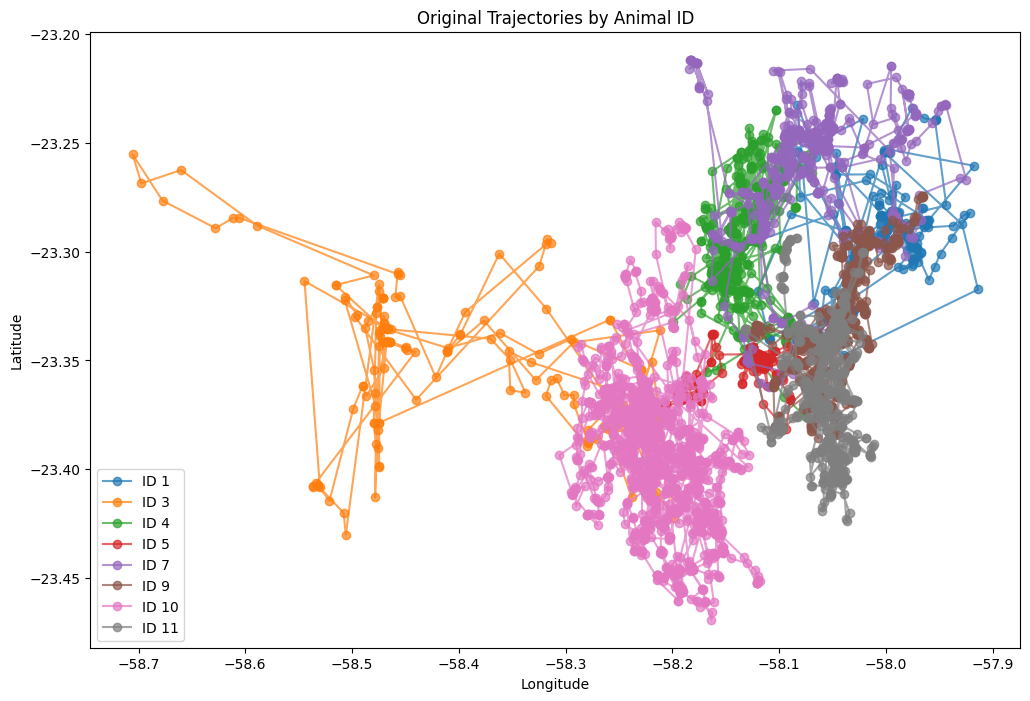

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[ 0.98229283  0.3428      1.86808753 -1.09939521  1.28042858  0.53571794
  -0.09868046  0.93862297 -0.06493581]
 [ 0.97691283  0.31409532 -0.91879552 -1.27800199  0.48890521  0.05850974
   0.62388694 -0.40606685 -1.20987978]
 [ 0.9786992   0.3357402   1.86808753 -1.27800199  0.48890521  0.05850974
   0.62388694 -0.40606685 -0.06493581]
 [ 1.00470078  0.672419    1.03202261 -1.06827433  0.92021026  1.91905363
  -0.06898591  0.63293966 -0.6374078 ]
 [ 1.00716618  0.67137166  1.58939922 -1.06827433  0.92021026  1.91905363
  -0.06898591  0.63293966 -1.20987978]]
Future predicted coordinates: [[-58.02711  -23.309076]

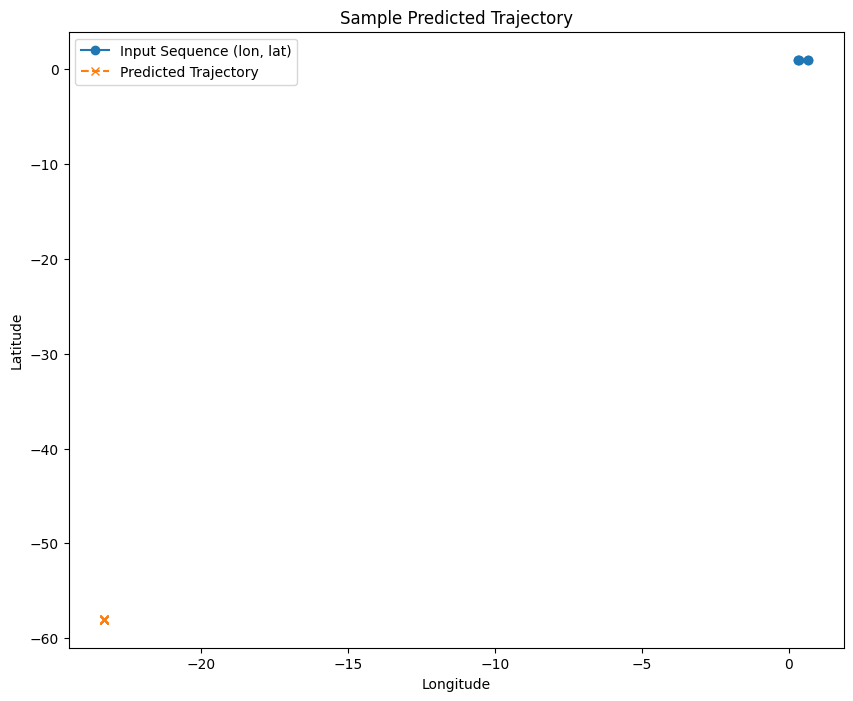

In [39]:
if __name__ == "__main__":
    main()